In [1]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [2]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap='gray')
        plt.title(window_name)
        plt.show()

## Task 2. Template Matching    
In this task, we will implement template matching using Sum
Square Difference and normalized cross-correlation similarity measures. The input
image is RidingBike.jpeg and the template image (what we want to find in the
larger input image) is RidingBikeTemplate.jpeg

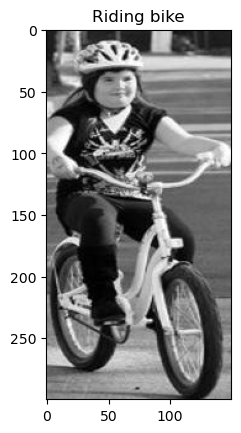

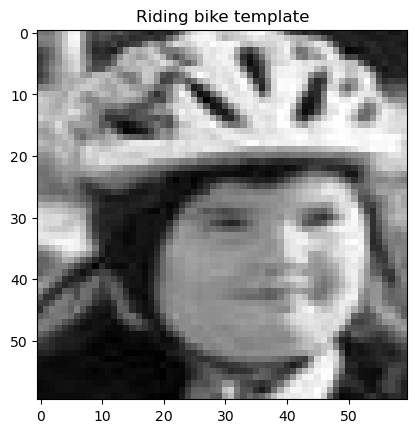

In [3]:
# set images pathes
riding_bike_path = '../data/ridingBike.jpeg'
riding_bike_template_path = '../data/ridingBikeTemplate.jpeg'
# read imgs
riding_bike = cv.imread(riding_bike_path, cv.IMREAD_GRAYSCALE)
riding_bike_template = cv.imread(riding_bike_template_path, cv.IMREAD_GRAYSCALE)

display_image('Riding bike', riding_bike)
display_image('Riding bike template', riding_bike_template)

* Implement Sum Square Difference.

$$
h[n, m] = \sum_{k,l}^{}(g[k,l] - f[m+k, n+l])^2
$$

In [4]:
def sum_squared_diff(im_1, im_2):
    """
    Computes the sum of squared differences between two images.
    """
    return np.sum(np.square(np.subtract(im_2, im_1)))

* Implement template matching using your implementation of Sum Square Difference.

In [5]:
def templ_matching_ssd(image, template):
    """
    Computes the sum of squared differences between the template and every possible location in the image.
    :param im: image to search in
    :param template: template to search for
    :return: image with the sum of squared differences
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32
    )
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = sum_squared_diff(
                image[i : i + template_h, j : j + template_w], template
            )

    return result

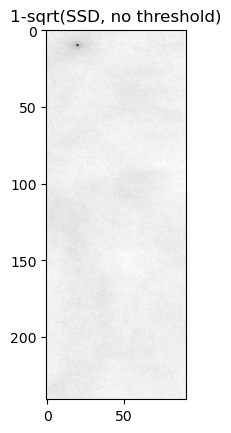

In [6]:
similarity_ssd_img = templ_matching_ssd(riding_bike, riding_bike_template)
similarity_ssd_img = similarity_ssd_img / similarity_ssd_img.max()
display_image('1-sqrt(SSD, no threshold)', similarity_ssd_img)

## for some reason detection is shown with lower values

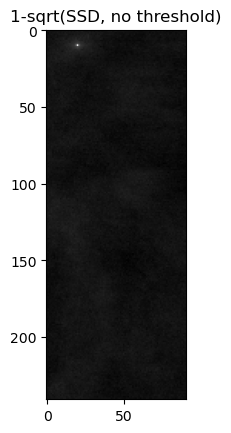

In [7]:
## I will use 1 - similarity_ssd_img to get the same result as in the lecture

similarity_ssd_img = 1 - similarity_ssd_img
display_image('1-sqrt(SSD, no threshold)', similarity_ssd_img)

* Implement Normalized Cross-correlation.

$$
h[n, m] = \frac{\sum_{k,l}^{}(g[k,l] - \bar{g})- (f[m+k, n+l] - \bar{f_{m,n}})}{\left(\sum_{k,l}^{}(g[k,l] - \bar{g})^2 \sum_{k,l}^{}(f[m+k, n+l] - \bar{f_{m,n}})^2\right)^{0.5}}
$$

In [16]:
def normalized_cross_correlation(im_1, im_2):
    """
    Computes the normalized cross correlation between two images.
    """
    im_1_mean = np.mean(im_1)
    im_2_mean = np.mean(im_2)

    norm = np.sqrt(
                np.sum(np.power(im_2 - im_2_mean, 2))
                * np.sum(np.power(im_1 - im_2_mean, 2))
            )

    return np.sum(np.multiply(im_2 - im_2_mean, im_1 - im_1_mean)) / norm
    

* Implement template matching using Normalized Cross-correlation.

In [9]:
def templ_matching_nxc(image, template):
    """
    Computes the normalized cross correlation between the template and every possible location in the image.
    :param image: image to search in
    :param template: template to search for
    :return: image with the normalized cross correlation
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32
    )
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = normalized_cross_correlation(
                image[i : i + template_h, j : j + template_w], template
            )
    if result.min() < 0:
        result = result - result.min()
    result /= result.max()
    return result

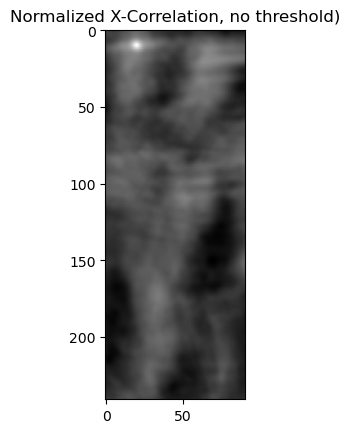

In [10]:
similarity_nxc_img = templ_matching_nxc(riding_bike, riding_bike_template)
similarity_nxc_img = similarity_nxc_img - similarity_nxc_img.min()
similarity_nxc_img = similarity_nxc_img / similarity_nxc_img.max()
display_image('Normalized X-Correlation, no threshold)', similarity_nxc_img)

* Draw rectangles on the image where similarity ≥ 0.5 for both methods. You
may experiment with other threshold values to determine the matching.

In [11]:
def draw_rectangle_at_detection(image, template_shape, detection_positions):
    detection_positions = zip(detection_positions[0], detection_positions[1])
    for detection_position in detection_positions:
        cv.rectangle(
            image,
            (detection_position[1], detection_position[0]),
            (detection_position[1] + template_shape[1], detection_position[0] + template_shape[0]),
            0
        )
    return image

(array([10], dtype=int64), array([20], dtype=int64))


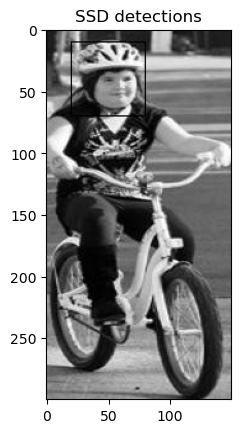

In [12]:
threshold = 0.5
detections = np.where(similarity_ssd_img >= threshold)
print(detections)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image('SSD detections', result)

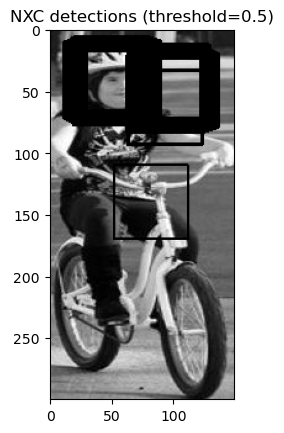

In [13]:
threshold = 0.5
detections = np.where(similarity_nxc_img >= threshold)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image('NXC detections (threshold=0.5)', result)

ok, too many false positive detections
lets make threshold higher

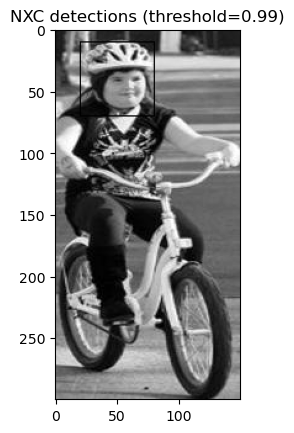

In [14]:
threshold = 0.99
detections = np.where(similarity_nxc_img >= threshold)
result = draw_rectangle_at_detection(riding_bike.copy(), riding_bike_template.shape, detections)

display_image(f'NXC detections (threshold={threshold})', result)